
#  オペレーティングシステム 演習 05
#  Linux CFSスケジューラ, vruntime


名前と学生証番号を書け. Enter your name and student ID.

 * 名前 Name:
 * 学生証番号 Student ID:


# 1. Linux CFSスケジューラ


* OSによるスケジューリングの基本
  * 中断しているスレッドと実行可能なスレッドを区別する
  * 実行可能なスレッドに公平にCPU時間を割り当てる

* 公平にCPU時間を割り当てる方法は色々あるがLinux のデフォルトスケジューラである, Complete Fair Scheduler (CFS) はCPUの利用時間累計を記録して, スレッド切り替え(実行中スレッドが中断した, 中断中スレッドが復帰した, タイマ割り込みがおきたなど)のタイミングで, それが最も少ないものに割り当てるという自然なもの
* CFSではCPUの利用時間累計を, スレッドごとに vruntime という変数を割り当てて管理してる. すなわち使ったCPU時間だけvruntimeを加算し, 次に実行するスレッドを選ぶときにvruntime最小のスレッドにCPU時間を割り当てるのがCFSの基本である
* しかしvruntimeに文字通りのCPU利用時間累計を記録していくと, 生まれたばかりのスレッドはvruntime=0, また, ほとんどCPUを使わずにずっと中断していたスレッドも vruntime $\approx$ 0ということになり, それらのスレッドが急に計算を始めると, それらに長時間CPUが連続して割り当てられる(すでにCPUを10秒消費しているスレッドには10秒間順番がまわってこない)ということになりかねない
* したがってvruntimeは以下のような管理がなされる

1. 親スレッドAが子スレッドBを生成した時, BはAのvruntimeを引き継ぐ (プロセスの場合も同様)
   Bのvruntime = Aのvruntime
2. 実行中のスレッドAから別のスレッドBに実行が切り替わる(コンテクストスイッチ)時
   Aのvruntime += Aが今回消費した時間
3. 中断中のスレッドAが復帰する時
   Aのvruntime += max(Aのvruntime, min { tのvruntime | t : 実行可能なスレッド})



* 以下のプログラムはvruntimeをずっと観測し続け, 時間とともにどう変化したかを記録する
* 以下が実際のCコード


In [1]:

%%writefile vruntime_rec.c
#define _GNU_SOURCE
#include <assert.h>
#include <sched.h>
#include <time.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <unistd.h>

/* 時刻 begin -- end まで proc 上で動いていた記録 */
typedef struct {
  double begin;
  double end;
  double vruntime;
  int proc;
} rec_t;

/* 現在時刻を得る */
double cur_time() {
  struct timespec tp[1];
  clock_gettime(CLOCK_REALTIME, tp);
  return tp->tv_sec + tp->tv_nsec * 1.0e-9;
}


double cur_vruntime() {
  char buf[100];
  char field[100];
  double val;
  FILE * fp = fopen("/proc/self/sched", "rb");
  char * r;
  int x;
  r = fgets(buf, sizeof(buf), fp);
  assert(r);
  r = fgets(buf, sizeof(buf), fp);
  assert(r);
  assert(strcmp("-------------------------------------------------------------------\n",
		buf) == 0);
  fseek(fp, 68, SEEK_CUR);
  r = fgets(buf, sizeof(buf), fp);
  if (!r) {
    perror("fgets"); 
    fclose(fp);
    exit(1);
  }
  fclose(fp);
  //printf("%s", buf);
  x = sscanf(buf, "%s : %lf\n", field, &val);
  assert(x == 2);
  assert(strcmp(field, "se.vruntime") == 0);
  //printf("%s=%f\n", field, val);
  return val;
}

/* T秒間走り続け, vruntimeの変化を記録する */
int run(double T,
        long n) {
  pid_t pid = getpid();
  double limit = cur_time() + T;
  rec_t * R = (rec_t *)calloc(n, sizeof(rec_t));
  long i = 0;
  R[i].begin = R[i].end = cur_time();
  R[i].vruntime = cur_vruntime();
  R[i].proc = sched_getcpu();
  while (R[i].end < limit && i < n) {
    double t = cur_time(); /* 現在時刻を得る */
    double vr = cur_vruntime();
    int proc = sched_getcpu();
    if (vr == R[i].vruntime && proc == R[i].proc) {
      /* 最後に見たvruntimeと変化なし */
      R[i].end = t;
      R[i].vruntime = vr;
    } else {
      /* vruntimeが変化している -> 新しい区間に入る */
      if (i + 1 >= n) break;
      i++;
      R[i].proc = proc;
      R[i].begin = R[i].end = cur_time();
      R[i].vruntime = cur_vruntime();
    }
  }
  assert(i < n);
  int j;
  for (j = 0; j <= i; j++) {
    printf("%d %d %f %f %f %f\n", 
	   pid, R[j].proc,
           R[j].begin, R[j].end, R[j].end - R[j].begin,
           R[j].vruntime);
  }
  return 0;
}

int main(int argc, char ** argv) {
  long i = 1;
  double T     = (argc > i ? atof(argv[i]) : 10.0);    i++; /* 合計時間 */
  long n       = (argc > i ? atoi(argv[i]) : 1000000); i++;
  run(T, n);
  return 0;
}

Writing vruntime_rec.c


In [2]:

gcc -Wall -o vruntime_rec vruntime_rec.c


* 以下は1秒ほど, 単独で走らせてみて, 出力の最初の10行を表示する例
* 出力1行の読み方は以下
```
プロセスID CPU番号 区間開始時刻  区間終了時刻  区間の長さ その間のvruntime
```
* 各行は, vruntimeが変わらなかった区間を表している


In [3]:
taskset -c 2 ./vruntime_rec 3 > vr.0
head vr.0

152337 2 1697591190.035589 1697591190.037328 0.001739 4102205.086119
152337 2 1697591190.037371 1697591190.041340 0.003969 4102207.330280
152337 2 1697591190.041377 1697591190.045341 0.003965 4102211.327658
152337 2 1697591190.045378 1697591190.049327 0.003949 4102215.326683
152337 2 1697591190.049362 1697591190.053338 0.003977 4102219.326150
152337 2 1697591190.053374 1697591190.057330 0.003956 4102223.326603
152337 2 1697591190.057377 1697591190.061331 0.003954 4102227.330689
152337 2 1697591190.061378 1697591190.065335 0.003957 4102231.315557
152337 2 1697591190.065394 1697591190.069332 0.003938 4102235.315725
152337 2 1697591190.069366 1697591190.073331 0.003964 4102239.315319



* なお以下の taskset -c 2 は processor (仮想コア) 2番 だけで実行せよという指示
* これはそのスレッドが1つの仮想コアでしか実行されないようにするための仕掛け(2番であることには意味はない)
* vruntime はprocessorごとに別々に管理されているため, スレッドがprocessor間を移動するとvruntimeは急に変化する(それはそれで見ておくと良い)



# 2. 可視化
* 以下が結果を可視化するプログラム


In [4]:
#!/usr/bin/python3
import sys
import re
import matplotlib.collections as mc
import matplotlib.pyplot as plt
import numpy as np

def read_dat(dat):
    pat = re.compile("(?P<pid>\d+) (?P<cpu>\d+) (?P<begin>\d+\.\d+) (?P<end>\d+\.\d+) (?P<dt>\d+\.\d+) (?P<vruntime>\d+)")
    log = {}
    with open(dat) as fp:
        for line in fp:
            m = pat.match(line)
            if not m:
                sys.stderr.write("warning: ignore line [%s]\n" % line.rstrip())
                continue
            pid = int(m.group("pid"))
            cpu = int(m.group("cpu"))
            begin = float(m.group("begin"))
            end = float(m.group("end"))
            dt = float(m.group("dt"))
            vruntime = int(m.group("vruntime"))
            if pid not in log:
                log[pid] = []
            log[pid].append((begin, end, vruntime, cpu))
    return log

def read_dats(dats):
    log = {}
    for dat in dats:
        log.update(read_dat(dat))
    return log

def vruntime_vis(files, start_t=0, end_t=float("inf")):
    log = read_dats(files)
    n_procs = len(log)
    n_cpus = max(max(cpu for _, _, _, cpu in recs) for recs in log.values()) + 1
    cmap = plt.cm.get_cmap('RdYlGn', n_procs)
    T0 = min(min(begin for begin, _, _, _ in recs) for recs in log.values())
    V0 = min(min(vrunt for _, _, vrunt, _ in recs) for recs in log.values())
    segs = []
    cols = []
    fig, ax = plt.subplots()
    for i, (pid, recs) in enumerate(log.items()):
        recs.sort()
        for begin, end, vruntime, cpu in recs:
            t0 = max(begin - T0, start_t)
            t1 = min(end - T0, end_t)
            if t0 >= t1:
                continue
            c = cmap(i)
            segs.append([(t0, vruntime), (t1, vruntime)])
            cols.append(c)
    wc = mc.LineCollection(segs, colors=cols, linewidths=3)
    ax.add_collection(wc)
    ax.autoscale()
    plt.title("thread vruntime")
    plt.xlabel("time")
    plt.ylabel("vruntime")
    plt.savefig("vruntime.svg")
    plt.show()
    
# usage:
# if you have n processes
# vruntime_vis(["vr.{}".format(i) for i in range(n)])


* 以下で実際に可視化


/tmp/ipykernel_152069/4012078638.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn', n_procs)


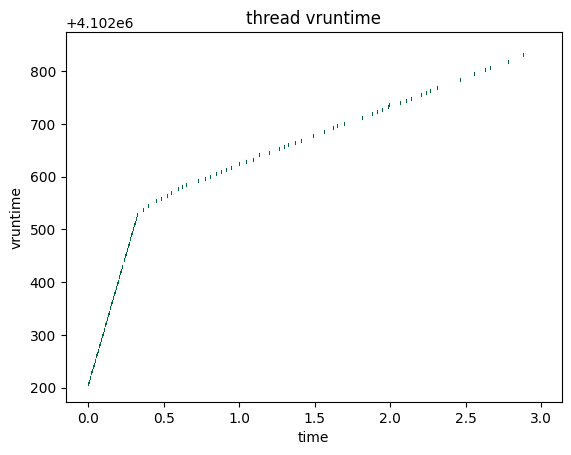

In [5]:

vruntime_vis(["vr.0"])

* 特定の領域を可視化するには, `start_t=開始時刻, end_t=終了時刻` を与える
* 一見して連続的に変化しているように見えるが, 狭い範囲をどんどん拡大してみると, 区間ごとに一定で, それが定期的に, 階段状に増加していることがわかる
* 以下の引数を変更して小さな区間を拡大表示してみよ

* 下記を実行するとvruntime.svgというSVG (ベクタ画像)ファイルが生成されるので, ある程度まで拡大表示した画像をダウンロードして適当な画像ビューアで拡大しても良い


/tmp/ipykernel_152069/4012078638.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn', n_procs)


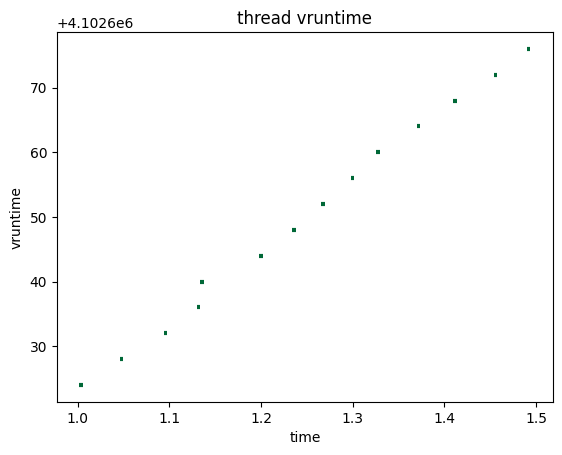

In [6]:
vruntime_vis(["vr.0"], start_t=1.0, end_t=1.5)

# 3. taskset でスレッドをprocessorに固定しない場合
* taskset でスレッドを特定のprocessorに固定しない場合, スレッドがprocessor間を動き回れるようになる
* 実際にスレッドがprocessor間を移動するかはわからないが, 途中でvruntime値が大きくジャンプしたらそれはおそらくprocessor (仮想コア)間をスレッドが移動したとき


In [7]:

./vruntime_rec 3 > vr.0

/tmp/ipykernel_152069/4012078638.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn', n_procs)


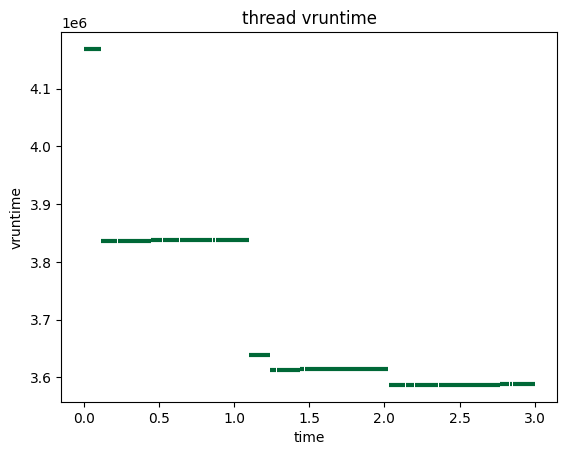

In [8]:

vruntime_vis(["vr.0"])
# vruntime_vis(["vr.0"], start_t=1.0, end_t=1.5)


# 4. 複数のスレッドがいる場合
* 以下はシェルスクリプトで同時に4個, 3秒間このプロセスを走らせ, 結果はファイル vr.0, vr.1, vr.2, vr.3 に記録したもの
* tasksetコマンドですべて同じprocessor (仮想コア) で実行するようにしている


In [15]:

for i in $(seq 0 3); do
  taskset -c 2 ./vruntime_rec 3 > vr.${i} &
done
wait

[1] 156481
[2] 156482
[3] 156483
[4] 156484
[1]   Done                    taskset -c 2 ./vruntime_rec 3 > vr.${i}
[2]   Done                    taskset -c 2 ./vruntime_rec 3 > vr.${i}
[3]-  Done                    taskset -c 2 ./vruntime_rec 3 > vr.${i}



* 実行し終えたら再び可視化せよ
* 適切に短い区間を拡大表示するなどして4つのプロセスのvruntimeがどのように増えていくかを観察せよ


/tmp/ipykernel_152069/4012078638.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn', n_procs)


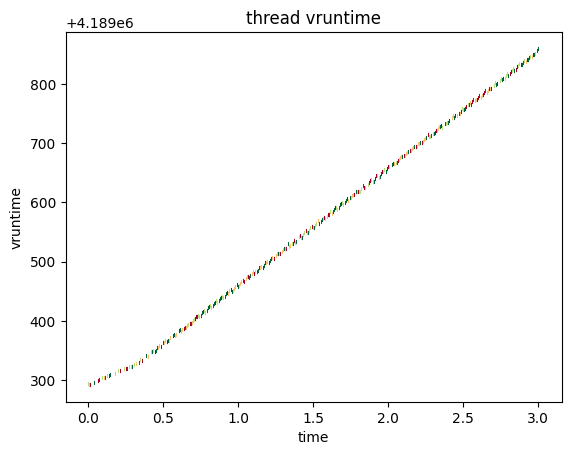

In [16]:
vruntime_vis(["vr.0", "vr.1", "vr.2", "vr.3"])
#vruntime_vis(["vr.0", "vr.1", "vr.2", "vr.3"], start_t=1.0, end_t=1.5)

* なお, プロセス数が多いときにも通用するもう少しスマートな書き方は以下 (これは純粋にPythonの話)

/tmp/ipykernel_152069/4012078638.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn', n_procs)


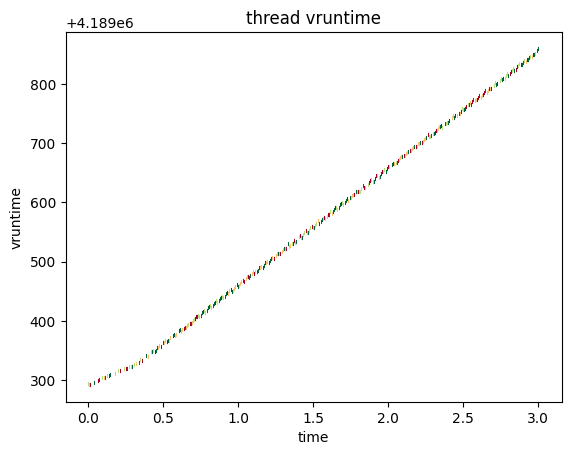

In [17]:
vruntime_vis([f"vr.{i}" for i in range(4)])
#vruntime_vis([f"vr.{i}" for i in range(4)], start_t=1.0, end_t=1.5)


# 5. Blockしている間はvruntimeは増えない
* 「vruntimeはCPUを使っていない時間は増えない」ことを確かめるために, 先のプログラムを少し走っては少し休むように変更したものが以下

```
./vruntime_rec_slp T R S
```

とすると, 「R秒走ってS秒sleepする」を, 合計T秒間繰り返す


In [18]:

%%writefile vruntime_rec_slp.c
#define _GNU_SOURCE
#include <assert.h>
#include <sched.h>
#include <time.h>
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <unistd.h>

/* 時刻 begin -- end まで proc 上で動いていた記録 */
typedef struct {
  double begin;
  double end;
  double vruntime;
  int proc;
} rec_t;

/* 現在時刻を得る */
double cur_time() {
  struct timespec tp[1];
  clock_gettime(CLOCK_REALTIME, tp);
  return tp->tv_sec + tp->tv_nsec * 1.0e-9;
}

void sleep_sec(double slp_t) {
  struct timespec tp[1];
  tp->tv_sec = (long)slp_t;
  tp->tv_nsec = (slp_t - (long)slp_t) * 1.0e9;
  nanosleep(tp, 0);
}

double cur_vruntime() {
  char buf[100];
  char field[100];
  double val;
  FILE * fp = fopen("/proc/self/sched", "rb");
  char * r;
  int x;
  r = fgets(buf, sizeof(buf), fp);
  assert(r);
  r = fgets(buf, sizeof(buf), fp);
  assert(r);
  assert(strcmp("-------------------------------------------------------------------\n",
		buf) == 0);
  fseek(fp, 68, SEEK_CUR);
  r = fgets(buf, sizeof(buf), fp);
  if (!r) {
    perror("fgets"); 
    fclose(fp);
    exit(1);
  }
  fclose(fp);
  //printf("%s", buf);
  x = sscanf(buf, "%s : %lf\n", field, &val);
  assert(x == 2);
  assert(strcmp(field, "se.vruntime") == 0);
  //printf("%s=%f\n", field, val);
  return val;
}

/* T秒間走り続け, vruntimeの変化を記録する */
int run(double T,
        double run_t, double slp_t,
        long n) {
  pid_t pid = getpid();
  double limit = cur_time() + T;
  rec_t * R = (rec_t *)calloc(n, sizeof(rec_t));
  long i = 0;
  sleep_sec(slp_t);
  double start = R[i].begin = R[i].end = cur_time();
  R[i].vruntime = cur_vruntime();
  R[i].proc = sched_getcpu();
  while (R[i].end < limit && i < n) {
    double t = cur_time(); /* 現在時刻を得る */
    double vr = cur_vruntime();
    int proc = sched_getcpu();
    if (vr == R[i].vruntime && proc == R[i].proc) {
      /* 最後に見たvruntimeと変化なし */
      R[i].end = t;
      R[i].vruntime = vr;
    } else {
      /* vruntimeが変化している -> 新しい区間に入る */
      if (i + 1 >= n) break;
      i++;
      R[i].proc = proc;
      R[i].begin = R[i].end = cur_time();
      R[i].vruntime = cur_vruntime();
    }
    if (t > start + run_t) {
      sleep_sec(slp_t);
      start = cur_time();
    }
  }
  assert(i < n);
  int j;
  for (j = 0; j <= i; j++) {
    printf("%d %d %f %f %f %f\n", 
	   pid, R[j].proc,
           R[j].begin, R[j].end, R[j].end - R[j].begin,
           R[j].vruntime);
  }
  return 0;
}

int main(int argc, char ** argv) {
  long i = 1;
  double T     = (argc > i ? atof(argv[i]) : 10.0);    i++; /* 合計時間 */
  double run_t = (argc > i ? atof(argv[i]) : T);       i++; /* 1回走り続ける時間 */
  double slp_t = (argc > i ? atof(argv[i]) : 0);       i++; /* 1回sleepする時間 */
  long n       = (argc > i ? atoi(argv[i]) : 1000000); i++;
  run(T, run_t, slp_t, n);
  return 0;
}

Writing vruntime_rec_slp.c


In [19]:

gcc -Wall -o vruntime_rec_slp vruntime_rec_slp.c

* 実行

In [20]:

taskset -c 2 ./vruntime_rec_slp 3 0.2 0.1 > vr.0

* vruntime可視化

/tmp/ipykernel_152069/4012078638.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn', n_procs)


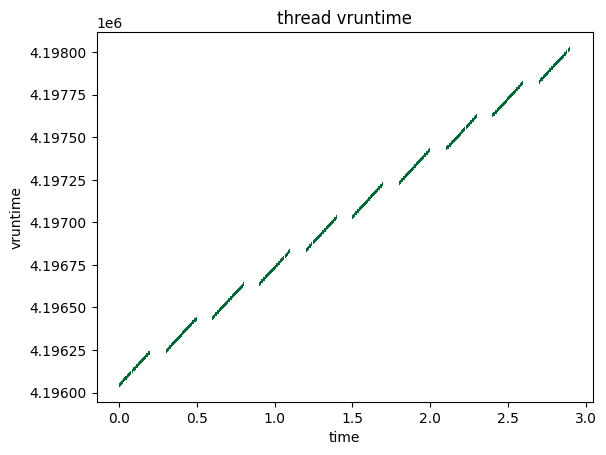

In [21]:
vruntime_vis(["vr.0"])
#vruntime_vis(["vr.0"], start_t=1.0, end_t=1.5)


* ずっとCPUを使っているスレッドの傍ら, 少し走っては少しsleepを繰り返すスレッドがいた場合, 後者がsleepから目覚めたときのvruntimeには何が起きているか
* 以下は
  * 0.2秒走って0.1秒sleep する (./vruntime_rec_slp 3 0.2 0.1) を1つと
  * ずっと走る (./vruntime_rec_slp 3 3 0) を3つ
同時に走らせる


In [22]:
for i in $(seq 0 3); do
  if [ ${i} = 0 ]; then
    taskset -c 2 ./vruntime_rec_slp 3 0.2 0.1 ;
  else
    taskset -c 2 ./vruntime_rec_slp 3 3 0 ;
  fi > vr.${i} &
done
wait

[1] 157053
[2] 157054
[3] 157055
[4] 157056
[1]   Done                    if [ ${i} = 0 ]; then
    taskset -c 2 ./vruntime_rec_slp 3 0.2 0.1;
else
    taskset -c 2 ./vruntime_rec_slp 3 3 0;
fi > vr.${i}
[2]   Done                    if [ ${i} = 0 ]; then
    taskset -c 2 ./vruntime_rec_slp 3 0.2 0.1;
else
    taskset -c 2 ./vruntime_rec_slp 3 3 0;
fi > vr.${i}
[3]-  Done                    if [ ${i} = 0 ]; then
    taskset -c 2 ./vruntime_rec_slp 3 0.2 0.1;
else
    taskset -c 2 ./vruntime_rec_slp 3 3 0;
fi > vr.${i}
[4]+  Done                    if [ ${i} = 0 ]; then
    taskset -c 2 ./vruntime_rec_slp 3 0.2 0.1;
else
    taskset -c 2 ./vruntime_rec_slp 3 3 0;
fi > vr.${i}


* 可視化

/tmp/ipykernel_152069/4012078638.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn', n_procs)


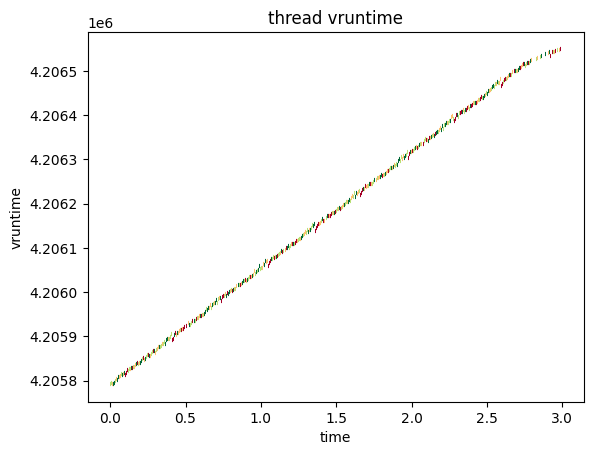

In [23]:
vruntime_vis([f"vr.{i}" for i in range(4)])
#vruntime_vis([f"vr.{i}" for i in range(4)], start_t=1.0, end_t=1.5)

# 6. niceの効果
* niceというコマンドならびにシステムコールがある
* プロセスの「nice値」を決めるもので, nice値が高い = 他のプロセスに実行をよく譲る(だからnice) = 優先度を非掬するというもの

```
nice -19 コマンド
```

は「コマンド」の「nice値」を19 (最大)にする. 同名のシステムコールもある.

* デフォルトのnice値は0. 正の値は多少なりとも優先度を下げるという意味になる

* nice値大きいプロセスと普通のプロセスが並走すると, ほとんどの時間を後者が消費するようになる

* CFSスケジューラでniceがどのように実現されているのかをvruntimeを観測することで考えてみよ

In [24]:
for i in $(seq 0 3); do
  if [ ${i} = 0 ]; then
    taskset -c 2 nice -5 ./vruntime_rec 3 ;
  else
    taskset -c 2 ./vruntime_rec 3 ;
  fi > vr.${i} &
done
wait

[1] 157255
[2] 157256
[3] 157257
[4] 157258
[1]   Done                    if [ ${i} = 0 ]; then
    taskset -c 2 nice -5 ./vruntime_rec 3;
else
    taskset -c 2 ./vruntime_rec 3;
fi > vr.${i}
[4]+  Done                    if [ ${i} = 0 ]; then
    taskset -c 2 nice -5 ./vruntime_rec 3;
else
    taskset -c 2 ./vruntime_rec 3;
fi > vr.${i}
[2]-  Done                    if [ ${i} = 0 ]; then
    taskset -c 2 nice -5 ./vruntime_rec 3;
else
    taskset -c 2 ./vruntime_rec 3;
fi > vr.${i}
[3]+  Done                    if [ ${i} = 0 ]; then
    taskset -c 2 nice -5 ./vruntime_rec 3;
else
    taskset -c 2 ./vruntime_rec 3;
fi > vr.${i}


/tmp/ipykernel_152069/4012078638.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn', n_procs)


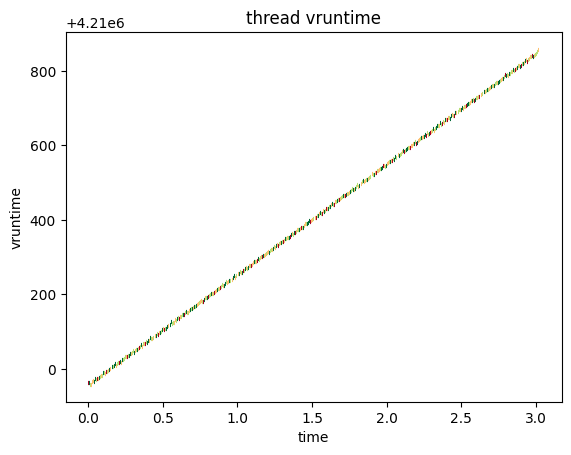

In [25]:
vruntime_vis([f"vr.{i}" for i in range(4)])
#vruntime_vis([f"vr.{i}" for i in range(4)], start_t=1.0, end_t=1.5)